In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
from custom_tools import create_hyperparameter_combinations
from sksurv.svm import FastSurvivalSVM
from baseline_hyperparams import FastSurvivalSVM_params, RandomSurvivalForest_params, GradientBoostingSurvivalAnalysis_params
import sksurv.util as su
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

# high tomır more lymphocytes
# hanahan and weinberg hallmat-rjs of canver
# n nighroe analysis

structured array with the first field indicating whether the actual survival time was observed or if was censored, and the second field denoting the observed survival time, which corresponds to the time of death (if Status == 'dead', then status=1) or the last time that person was contacted (if Status == 'alive', status = 0 ).



In [ ]:
dataset_name= "JacksonFischer"
dataset_path = os.path.join("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data", dataset_name)

def get_ct_classes():
    all_ct_class = set()

    for fl in os.listdir(os.path.join(dataset_path, "raw")):
        if fl.endswith("ct_class.pickle"):
            # print(fl)
            img, pid = fl.split("_")[:2]
            with open(os.path.join(dataset_path, "raw", f'{img}_{pid}_clinical_info.pickle'), 'rb') as handle:
                clinical_info_dict = pickle.load(handle)
            if pd.notna(clinical_info_dict["OSmonth"]):

                with open(os.path.join(dataset_path, "raw", f'{img}_{pid}_ct_class.pickle'), 'rb') as handle:
                    feature_arr = pickle.load(handle)
                    for ct_ann in feature_arr:
                        all_ct_class.add(ct_ann[0])

    return sorted(list(all_ct_class))


def get_dataset_df(agg="mean"):
    cell_type_list = get_ct_classes()
    wanted_label = "OSmonth"
    unit = "month"
    count = 0
    columns = []
    data_list = []
    for fl in os.listdir(os.path.join(dataset_path, "raw")):
        if fl.endswith("ct_class.pickle"):
            # print(fl)
            img, pid = fl.split("_")[:2]
            with open(os.path.join(dataset_path, "raw", f'{img}_{pid}_clinical_info.pickle'), 'rb') as handle:
                clinical_info_dict = pickle.load(handle)
            if pd.notna(clinical_info_dict["OSmonth"]):
                censored = None

                if "Patientstatus" in clinical_info_dict.keys():
                    censored = 0 if clinical_info_dict["Patientstatus"].lower().startswith("death") else 1
                elif "Overall Survival Status" in clinical_info_dict.keys():
                    censored = 0 if "deceased" in clinical_info_dict["Overall Survival Status"].lower() else 1

                with open(os.path.join(dataset_path, "raw", f'{img}_{pid}_ct_class.pickle'), 'rb') as handle:
                    
                    feature_arr = pickle.load(handle)
                    one_hot_fear_arr = []
                    for ct_ann in feature_arr:
                        ct_annot = ct_ann[0]
                        one_hot_list = [0]*len(cell_type_list)
                        ind_ct = cell_type_list.index(ct_annot)
                        one_hot_list[ind_ct] = 1
                        one_hot_fear_arr.append(one_hot_list)
                    

                    feature_arr = np.array(one_hot_fear_arr)
                    
                    if agg=="mean":
                        feature_arr = feature_arr.mean(axis=0)
                    elif agg=="sum":
                        feature_arr = feature_arr.sum(axis=0)

                row = feature_arr.copy()
                y_val = clinical_info_dict["OSmonth"]

                lst_clinical_info = clinical_info_dict.keys()
                lst_clinical_info = sorted(lst_clinical_info)

                if len(columns)==0:
                    for i in range(len(feature_arr)):
                        columns.append(f"Marker_{i}")
                    for ci in lst_clinical_info:
                        columns.append(ci)
                    columns.append("img_id")
                    columns.append("p_id")



                for key in lst_clinical_info:
                    row = np.append(row, clinical_info_dict[key])

                row = np.append(row, img)
                row = np.append(row, pid)

                data_list.append(row)
                # print(feature_arr)
                count+=1

    df_features = pd.DataFrame(data_list, columns=columns)
    return df_features, cell_type_list

In [ ]:
def load_json(file_path):
    """Loads the json file for given path

    Args:
        file_path (string): file path

    Returns:
        dict: dict of the json
    """
    
    with open(file_path, 'r') as fp:
        l_dict = json.load(fp)
    return l_dict

import json
json_fl = load_json("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/JacksonFischer/folds.json")

In [ ]:
aggregator = ["sum", "mean"]
estimators = ["FastSurvivalSVM", "RandomSurvivalForest", "GradientBoostingSurvivalAnalysis"]

hyper_param_combs_dict = {"FastSurvivalSVM":create_hyperparameter_combinations(FastSurvivalSVM_params), "RandomSurvivalForest":create_hyperparameter_combinations(RandomSurvivalForest_params), "GradientBoostingSurvivalAnalysis":create_hyperparameter_combinations(GradientBoostingSurvivalAnalysis_params)}


result_df_cols  = []
all_results = []
for agg in aggregator:
    df_dataset, cell_type_list = get_dataset_df(agg=agg)
    all_data_y =[]
    all_status = []
    for ind, row in df_dataset.iterrows():
        patient_status = True if row["Patientstatus"].lower().startswith("death") else False
        all_data_y.append((patient_status, float(row["OSmonth"])))
        all_status.append(patient_status)

    df_dataset["data_y"] = all_data_y
    df_dataset["status"] = all_status
    # print(df_dataset)

    # List to save sampler triplet
    samplers = []

    for fold in json_fl["fold_img_id_dict"]:
        train_idx = list(df_dataset.loc[df_dataset.img_id.isin(json_fl["fold_img_id_dict"][fold][0]),:].index)
        test_idx = list(df_dataset.loc[df_dataset.img_id.isin(json_fl["fold_img_id_dict"][fold][1]),:].index)

        samplers.append((
                (fold), # fold number
                (train_idx),
                (test_idx)))
    
    for est_name in estimators:
        hyper_param_combs = hyper_param_combs_dict[est_name]
        for ind, comb in enumerate(hyper_param_combs):
            
            result_df_cols.append(f"{est_name}-{ind}-{agg}")
            estimator = None
            if est_name == "FastSurvivalSVM":
                estimator = FastSurvivalSVM(**comb)
            elif est_name == "RandomSurvivalForest":
                estimator = RandomSurvivalForest(**comb)
            elif est_name == "GradientBoostingSurvivalAnalysis":
                estimator = GradientBoostingSurvivalAnalysis(**comb)
            else:
                raise Exception("Please enter a valid estimator...")
            

            k_fold_cindex = []
            for fold_id, train_idx, test_idx in samplers:
                train_df = df_dataset.iloc[train_idx]
                data_x = train_df.iloc[:,:len(cell_type_list)]
                data_y = su.Surv.from_arrays(train_df["status"], train_df["OSmonth"].astype("float").add(0.1))

                test_df = df_dataset.iloc[test_idx]
                test_data_x = test_df.iloc[:,:len(cell_type_list)]
                test_data_y = su.Surv.from_arrays(test_df["status"], test_df["OSmonth"].astype("float").add(0.1))
                estimator.fit(data_x, data_y)

                test_cindex = concordance_index_censored(
                test_df["status"],
                test_df["OSmonth"],
                estimator.predict(test_data_x))
                k_fold_cindex.append(test_cindex[0])
            all_results.append(k_fold_cindex)
            print(ind)
            if ind==2:
                break

print(len(all_results))
print(len(result_df_cols))
df_results = pd.DataFrame(np.array(all_results).T, columns=result_df_cols)

df_results.to_csv("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/out_data/baseline_predictors/baseline_ct_results.csv")


In [ ]:
get_ct_classes()

In [ ]:
df_dataset = get_dataset_df(agg="mean")

all_data_y =[]
all_status = []
for ind, row in df_dataset.iterrows():
    patient_status = True if row["Patientstatus"].lower().startswith("death") else False
    all_data_y.append((patient_status, float(row["OSmonth"])))
    all_status.append(patient_status)
    
df_dataset["data_y"] = all_data_y
df_dataset["status"] = all_status

In [ ]:
df_dataset

In [ ]:
k_fold_cindex = []
for fold_id, train_idx, test_idx in samplers:
    estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)
    train_df = df_dataset.iloc[train_idx]
    data_x = train_df.iloc[:,:len(cell_type_list)]
    data_y = su.Surv.from_arrays(train_df["status"], train_df["OSmonth"].astype("float").add(0.1))
    
    test_df = df_dataset.iloc[test_idx]
    test_data_x = test_df.iloc[:,:len(cell_type_list)]
    test_data_y = su.Surv.from_arrays(test_df["status"], test_df["OSmonth"].astype("float").add(0.1))
    estimator.fit(data_x, data_y)
    
    test_cindex = concordance_index_censored(
    test_df["status"],
    test_df["OSmonth"],
    estimator.predict(test_data_x))
    k_fold_cindex.append(test_cindex[0])

print(sum(k_fold_cindex)/len(k_fold_cindex))

In [ ]:
k_fold_cindex = []
scores = []
for fold_id, train_idx, test_idx in samplers:
    estimator = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1)
    train_df = df_dataset.iloc[train_idx]
    data_x = train_df.iloc[:,:len(cell_type_list)]
    data_y = su.Surv.from_arrays(train_df["status"], train_df["OSmonth"].astype("float").add(0.1))
    
    test_df = df_dataset.iloc[test_idx]
    test_data_x = test_df.iloc[:,:len(cell_type_list)]
    test_data_y = su.Surv.from_arrays(test_df["status"], test_df["OSmonth"].astype("float").add(0.1))
    estimator.fit(data_x, data_y)
    
    test_cindex = concordance_index_censored(
    test_df["status"],
    test_df["OSmonth"],
    estimator.predict(test_data_x))
    
    k_fold_cindex.append(test_cindex[0])

print(sum(k_fold_cindex)/len(k_fold_cindex))


In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
lst_results = []
lst_columns = []
lst_paths = [("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/out_data/baseline_predictors/baseline_ct_results.csv", "Cell Type Composition"), ("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/out_data/baseline_predictors/pseudobulk_results.csv", "Pseudobulk")]
for path_an in lst_paths:
    path, analysis = path_an
    df_results = pd.read_csv(path, index_col=0)
    # df_results = pd.read_csv("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/out_data/baseline_predictors/pseudobulk_results.csv", index_col=0)
    result_col_dict = dict()
    for col in df_results.columns:
        mdl, _, agg = col.split("-")
        try:
            result_col_dict[(mdl, agg)].append(col)
        except:
            result_col_dict[(mdl, agg)] = []
            result_col_dict[(mdl, agg)].append(col)

    for key in result_col_dict.keys():
        col = f"{analysis}-{key[0]}-{key[1]}"
        means = df_results[result_col_dict[key]].mean()
        max_value = means.max()
        max_id = means.idxmax()
        lst_results.append(list(df_results[max_id]))
        lst_columns.append(col)
        # print(list(df_results[max_id]))
        # print(key, means.max(), means.idxmax())

In [2]:
def load_json(file_path):
    """Loads the json file for given path

    Args:
        file_path (string): file path

    Returns:
        dict: dict of the json
    """
    
    with open(file_path, 'r') as fp:
        l_dict = json.load(fp)
    return l_dict

import json
jf_json = load_json("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/models/JacksonFischer/JF_xfold.json")


In [3]:
lst_results.append(jf_json["fold_ci_scores"])
lst_columns.append("SPADE")



In [4]:
df_final_results = pd.DataFrame(lst_results, lst_columns).transpose()

In [5]:
df_long = df_final_results.reset_index().melt(id_vars='index', var_name='Model', value_name='Score')


/tmp/ipykernel_3914573/1880603734.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Score', data=df_long, palette=palette)


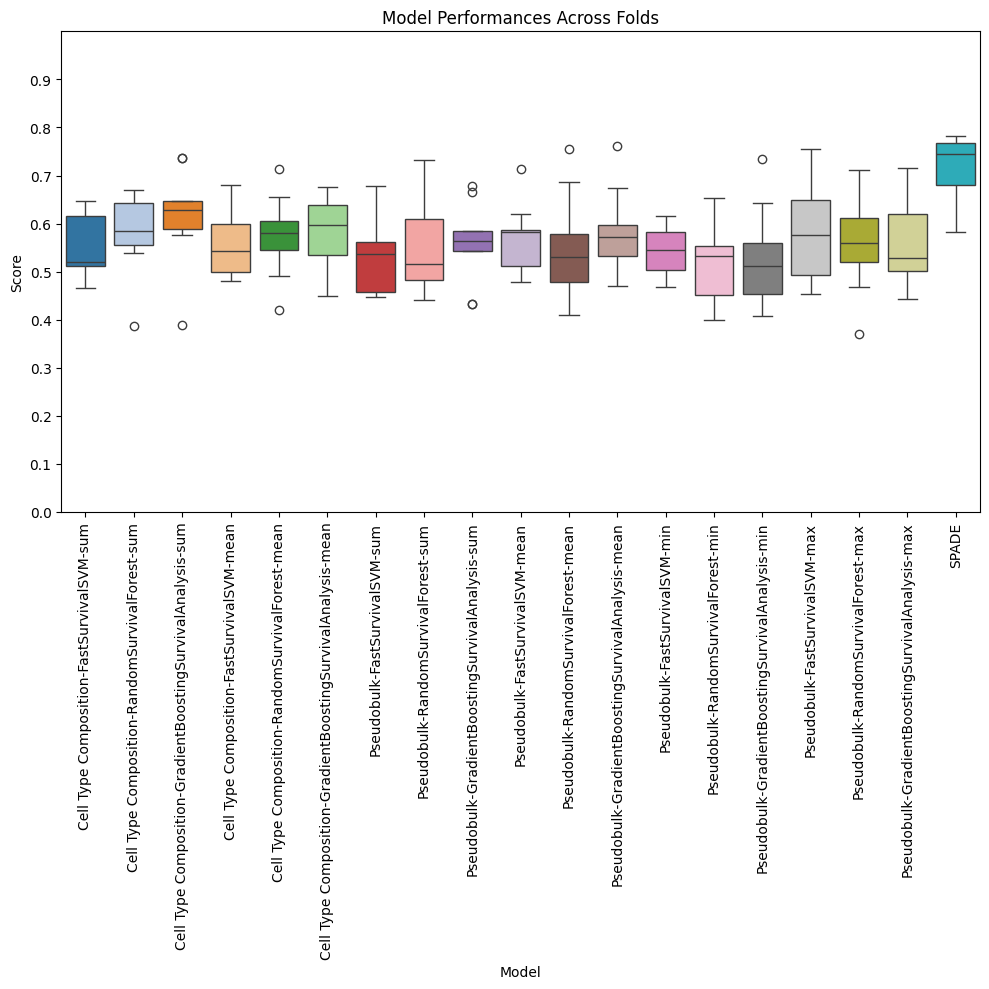

In [18]:
# Plotting the boxplot using Seaborn
plt.figure(figsize=(10, 10))
palette = sns.color_palette("tab20", len(df_final_results.columns))

sns.boxplot(x='Model', y='Score', data=df_long, palette=palette)
plt.xticks(rotation=90)
plt.title('Model Performances Across Folds')
plt.xlabel('Model')
plt.ylim(0,1.00)
plt.ylabel('Score')
plt.yticks(np.arange(0, 1, step=0.1))
plt.tight_layout()
plt.savefig("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/baseline_predictors/baseline_comparison.pdf", dpi=300)
plt.show()